In [6]:
import pandas as pd

# Load CSV
df = pd.read_csv("solar_wind.xlsx.csv")

# Convert 'Date and Hour' to datetime
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'])

# Filter for only Solar data
solar_df = df[df['Source'] == 'Solar']

# Group by date and sum production
solar_df['Date'] = solar_df['Date and Hour'].dt.date
daily_solar = solar_df.groupby('Date')['Production'].sum().reset_index()

# Add day index
daily_solar['day'] = range(len(daily_solar))

daily_solar.head()


C:\Users\wanzr\AppData\Local\Temp\ipykernel_4880\3728741094.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date and Hour'] = pd.to_datetime(df['Date and Hour'])


AttributeError: Can only use .dt accessor with datetimelike values

In [7]:
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'], errors='coerce')


In [8]:
print(df['Date and Hour'].dtype)


datetime64[ns, UTC+02:00]


In [9]:
# Force datetime conversion
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'], errors='coerce')

# Filter only solar data
solar_df = df[df['Source'] == 'Solar']

# Extract just the date (drop hour)
solar_df['Date'] = solar_df['Date and Hour'].dt.date

# Group by Date and sum up Production
daily_solar = solar_df.groupby('Date')['Production'].sum().reset_index()

# Add day index for ML model
daily_solar['day'] = range(len(daily_solar))

daily_solar.head()


C:\Users\wanzr\AppData\Local\Temp\ipykernel_4880\4089403004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_df['Date'] = solar_df['Date and Hour'].dt.date


,Date,Production,day
0,2020-04-01,23140.0,0
1,2020-04-02,23936.0,1
2,2020-04-03,29153.0,2
3,2020-04-04,32371.0,3
4,2020-04-05,30676.0,4


In [10]:
solar_df.loc[:, 'Date'] = solar_df['Date and Hour'].dt.date


In [11]:
# Convert datetime correctly
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'], errors='coerce')

# Filter for Solar
solar_df = df[df['Source'] == 'Solar'].copy()  # <-- this copy also avoids warnings

# Extract just the date part
solar_df.loc[:, 'Date'] = solar_df['Date and Hour'].dt.date

# Group by Date
daily_solar = solar_df.groupby('Date')['Production'].sum().reset_index()

# Add day index
daily_solar['day'] = range(len(daily_solar))

daily_solar.head()


,Date,Production,day
0,2020-04-01,23140.0,0
1,2020-04-02,23936.0,1
2,2020-04-03,29153.0,2
3,2020-04-04,32371.0,3
4,2020-04-05,30676.0,4


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Features and target
X = daily_solar[['day']]               # Input: Day index
y = daily_solar['Production']          # Output: Solar Production (MW)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


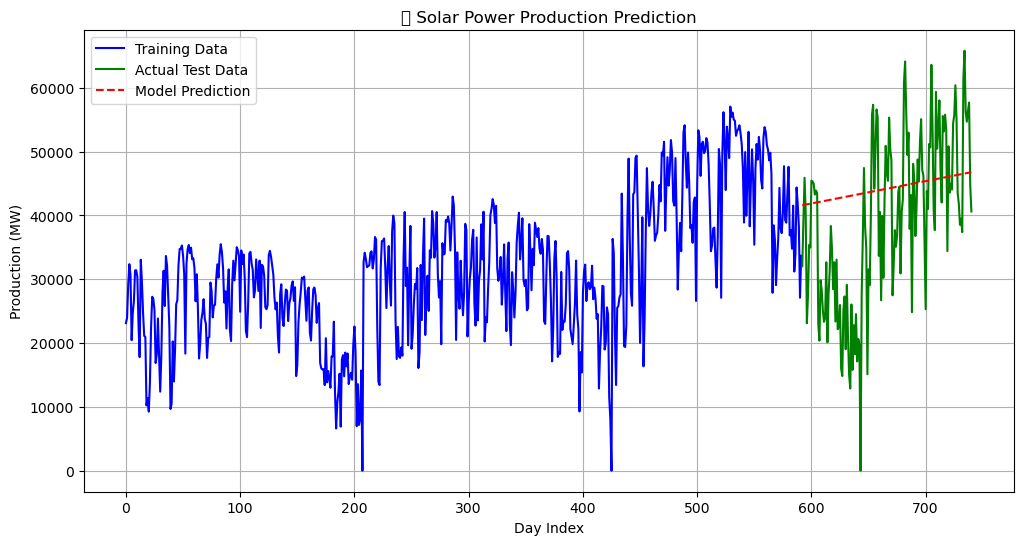

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual training data
plt.plot(X_train['day'], y_train, label='Training Data', color='blue')

# Plot actual test data
plt.plot(X_test['day'], y_test, label='Actual Test Data', color='green')

# Plot predicted values
plt.plot(X_test['day'], y_pred, label='Model Prediction', color='red', linestyle='--')

plt.title('🌞 Solar Power Production Prediction')
plt.xlabel('Day Index')
plt.ylabel('Production (MW)')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate RMSE manually
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate R²
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")


📉 RMSE: 13216.78
📈 R² Score: -0.02


In [16]:
# Recreate the date column as datetime
daily_solar['Date'] = pd.to_datetime(daily_solar['Date'])

# Add useful features
daily_solar['day_of_week'] = daily_solar['Date'].dt.dayofweek  # 0=Monday
daily_solar['month'] = daily_solar['Date'].dt.month

# Define X and y with new features
X = daily_solar[['day', 'day_of_week', 'month']]
y = daily_solar['Production']


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [18]:
from sklearn.ensemble import RandomForestRegressor

# Create and train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)


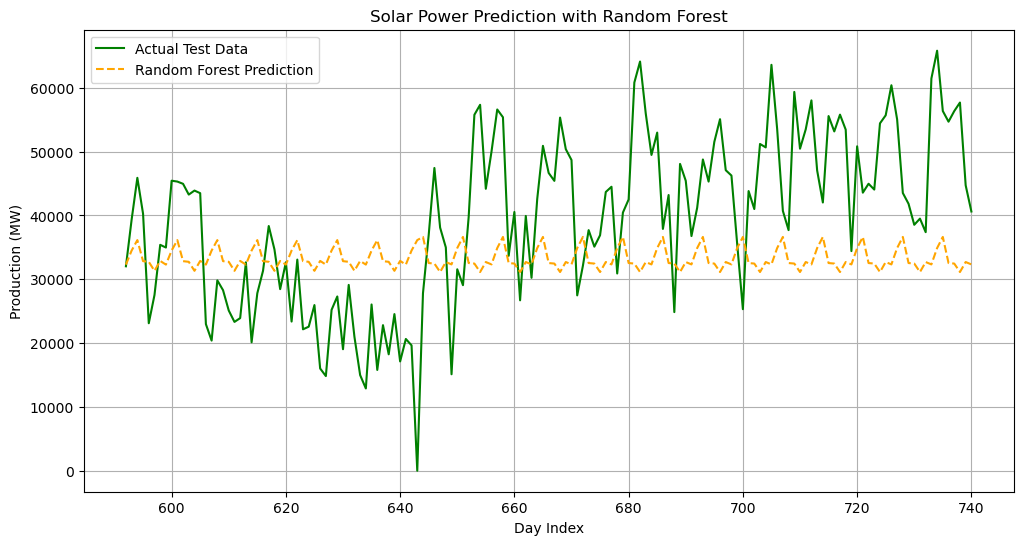

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Actual values
plt.plot(X_test['day'], y_test, label='Actual Test Data', color='green')

# Random Forest predictions
plt.plot(X_test['day'], y_pred_rf, label='Random Forest Prediction', color='orange', linestyle='--')

plt.title('Solar Power Prediction with Random Forest')
plt.xlabel('Day Index')
plt.ylabel('Production (MW)')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"📉 RMSE (Random Forest): {rmse_rf:.2f}")
print(f"📈 R² Score (Random Forest): {r2_rf:.2f}")


📉 RMSE (Random Forest): 14667.52
📈 R² Score (Random Forest): -0.25


In [22]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"📉 RMSE (Linear Regression): {rmse_lr:.2f}")
print(f"📈 R² Score (Linear Regression): {r2_lr:.2f}")


📉 RMSE (Linear Regression): 12465.05
📈 R² Score (Linear Regression): 0.09
